## Importing Libraries

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [2]:
import os
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive, files
from platform import python_version

print('Python Version: {}\nTensorflow Version: {}'.format(python_version(), tf.__version__))

Python Version: 3.7.12
Tensorflow Version: 2.7.0


## Loading Dataset

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.chdir('/content/gdrive/MyDrive/covid_xray_detection/dataset')
train_path = os.path.join(os.curdir, 'train')
test_path = os.path.join(os.curdir, 'test')

In [5]:
train_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test_labels.csv')
print('Number of Training Example: {}, Testing Examples: {}'.format(len(train_df), len(test_df)))

Number of Training Example: 30482, Testing Examples: 400


In [6]:
train_df.head()

,Unnamed: 0,filename,class
0,0,ARDSSevere.png,negative
1,1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,3,ards-secondary-to-tiger-snake-bite.png,negative
4,4,pneumocystis-pneumonia-2-PA.png,negative


In [7]:
def pair_img_labels(df,mode, num = 2000):
  img_lst = []
  label_lst = []
  start_index = df.index[0]
  if mode == 'train':
    print('Loading Training Data....')
    for index,row in df.iterrows():
      img_name = row['filename']
      label = row['class']
      if label == 'negative':
        onehot_label = 0
      if label == 'positive':
        onehot_label = 1
      label_lst.append(onehot_label)
      img_path = os.path.join(train_path, img_name)
      pil_img = Image.open(img_path)
      img_arr = np.asarray(pil_img).astype(np.uint8)
      if len(img_arr.shape) > 2 and img_arr.shape[2] == 4:
        #convert the image from RGBA2RGB
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGRA2BGR)

      img_arr = tf.convert_to_tensor(img_arr, dtype = tf.float32)

      if len(img_arr.shape) == 2:
        img_arr = tf.expand_dims(img_arr , axis= -1)
        img_arr = tf.image.grayscale_to_rgb(img_arr) #convert grayscale to rgb
      img_arr = tf.image.resize(img_arr, (299,299))
      img_lst.append(img_arr)
      if (index-start_index)>=(num-1):
        break
    print('Done!')
  elif mode == 'test':
    print('Loading Testing Data.....')
    for index,row in df.iterrows():
      img_name = row['filename']
      label = row['class']
      if label == 'negative':
        onehot_label = 0
      if label == 'positive':
        onehot_label = 1
      label_lst.append(onehot_label)
      img_path = os.path.join(test_path, img_name)
      pil_img = Image.open(img_path)
      img_arr = np.asarray(pil_img).astype(np.uint8)

      if len(img_arr.shape) > 2 and img_arr.shape[2] == 4:
        #convert the image from RGBA2RGB
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGRA2BGR)

      img_arr = tf.convert_to_tensor(img_arr, dtype = tf.float32)
      
      if len(img_arr.shape) == 2:
        img_arr = tf.expand_dims(img_arr , axis= -1)
        img_arr = tf.image.grayscale_to_rgb(img_arr)
      img_arr = tf.image.resize(img_arr, (299,299))
      img_lst.append(img_arr)
      if (index-start_index)>=(num-1):
        break
    print('Done!')
  else:
    print('Incorrect Mode, Select either test or train')
  return img_lst,label_lst

## Continue

In [8]:
train_1 = train_df.iloc[:3000,1:]
train_2 =train_df.iloc[3000:6000,1:]
train_3 = train_df.iloc[6000:9000,1:]

In [10]:
train_imgs1, train_labels1 = pair_img_labels(train_1, mode = 'train', num = 2000)

Loading Training Data....
Done!


In [11]:
test_imgs, test_labels = pair_img_labels(test_df, mode = 'test', num = len(test_df))

Loading Testing Data.....
Done!


In [ ]:
# train_imgs2, train_labels2 = pair_img_labels(train_2, mode = 'train', num = 3000)

In [ ]:
# train_imgs3, train_labels3 = pair_img_labels(train_3, mode = 'train', num = 3000)

## Visualizing Some Training Images

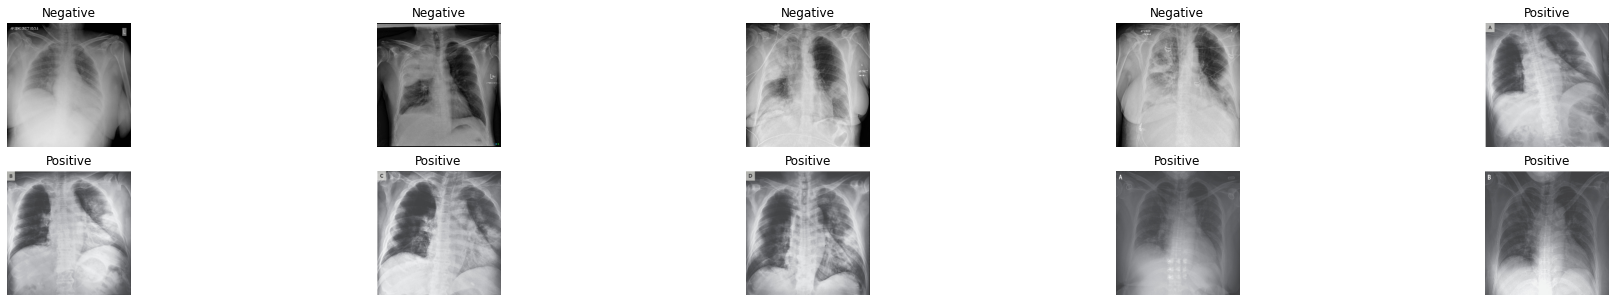

In [12]:
def return_title(label):
  if label == 0:
    return 'Negative'
  if label == 1:
    return 'Positive'

plt.figure(figsize = (32,5))  
for i in range(400,410):
  plt.subplot(2,5,i-399)
  plt.imshow((train_imgs1[i]).numpy().astype(np.int32))
  plt.title(return_title(train_labels1[i]))
  plt.axis('off') 

## Input Data Pipeline

In [13]:
batch_size = 20

def preprocess_data(image,label):
  image = tf.keras.applications.xception.preprocess_input(image)
  return image,label

def get_dataset_partitions(imgs,labels, ds_size, train_split=0.85, shuffle=True, shuffle_size=10000):
    ds = tf.data.Dataset.from_tensor_slices((imgs,labels))
    ds = ds.shuffle(shuffle_size,seed=30)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(ds_size-train_size)
    train_ds = train_ds.map(preprocess_data).batch(batch_size).prefetch(1)
    val_ds = val_ds.map(preprocess_data).batch(batch_size).prefetch(1)
    return train_ds, val_ds

In [14]:
train_ds1, val_ds1 = get_dataset_partitions(imgs=train_imgs1, labels = train_labels1, ds_size = len(train_imgs1))

In [15]:
print('Number of Training Batches: {}\nNumber of Validation Batches: {}'.format(len(train_ds1),len(val_ds1)))

Number of Training Batches: 85
Number of Validation Batches: 15


# Transfer Learning with Xception Model

In [16]:
base_model = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top = False)

head_model = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
head_model = tf.keras.layers.Dense(1, activation = 'sigmoid')(head_model)
final_model = tf.keras.models.Model(inputs = base_model.input, outputs = head_model)

for layer in base_model.layers:
  #Freeze the top Xception Layers with preloaded weights from imagenet
  layer.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


List of all the layers that are trainable

In [17]:
[print(layer) for layer in final_model.layers if layer.trainable]

[None, None]

In [18]:
final_model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.2, momentum= 0.9, decay = 0.01),
    loss = 'binary_crossentropy',
    metrics = ['acc',tf.keras.metrics.AUC()]
    )


### Callbacks

In [19]:
#early stopping to avoid overfitting the model
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience=3, 
    min_delta=0.01,
    restore_best_weights = True
    )

#tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Training the Model with bottom layers frozen

In [20]:
history =  final_model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs = 10,
    verbose = 1,
    callbacks = [earlystop_cb,tensorboard_callback]
)

final_model.save('saved_model')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
85/85 [==============================] - 37s 283ms/step - loss: 0.5241 - acc: 0.8100 - auc: 0.7648 - val_loss: 0.2863 - val_acc: 0.8633 - val_auc: 0.9233
Epoch 2/10
85/85 [==============================] - 22s 251ms/step - loss: 0.3378 - acc: 0.8682 - auc: 0.8783 - val_loss: 0.3263 - val_acc: 0.8800 - val_auc: 0.9028
Epoch 3/10
85/85 [==============================] - 22s 254ms/step - loss: 0.3385 - acc: 0.8782 - auc: 0.8864 - val_loss: 0.2351 - val_acc: 0.9133 - val_auc: 0.9306
Epoch 4/10
85/85 [==============================] - 24s 281ms/step - loss: 0.2702 - acc: 0.8935 - auc: 0.9219 - val_loss: 0.2352 - val_acc: 0.9167 - val_auc: 0.9476
Epoch 5/10
85/85 [==============================] - 22s 257ms/step - loss: 0.2294 - acc: 0.9135 - auc: 0.9417 - val_loss: 0.2203 - val_acc: 0.8933 - val_auc: 0.9614
Epoch 6/10
85/85 [==============================] - 23s 259ms/step - loss: 0.2151 - acc: 0.9129 - auc: 0.9531 - val_loss: 0.1922 - val_acc: 0.9333 - val_auc: 0.9667
Epoch 7/10

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Training with all layers trainable

In [21]:
for layer in base_model.layers:
  layer.trainable = True

final_model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum= 0.9, decay = 0.01),
    loss = 'binary_crossentropy',
    metrics = ['acc',tf.keras.metrics.AUC()]
    )

In [22]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience=3, 
    min_delta=0.001,
    restore_best_weights = True
    )


history =  final_model.fit(
    train_ds1.take(1000),
    validation_data=val_ds1,
    epochs = 20,
    verbose = 1,
    callbacks = [earlystop_cb,tensorboard_callback]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
85/85 [==============================] - 78s 835ms/step - loss: 0.3355 - acc: 0.8665 - auc_1: 0.8696 - val_loss: 0.1896 - val_acc: 0.9100 - val_auc_1: 0.9744
Epoch 2/20
85/85 [==============================] - 69s 809ms/step - loss: 0.1120 - acc: 0.9559 - auc_1: 0.9890 - val_loss: 0.2158 - val_acc: 0.9033 - val_auc_1: 0.9996
Epoch 3/20
85/85 [==============================] - 71s 835ms/step - loss: 0.0391 - acc: 0.9882 - auc_1: 0.9987 - val_loss: 0.0544 - val_acc: 0.9800 - val_auc_1: 0.9999
Epoch 4/20
85/85 [==============================] - 71s 835ms/step - loss: 0.0161 - acc: 0.9971 - auc_1: 0.9999 - val_loss: 0.0038 - val_acc: 1.0000 - val_auc_1: 1.0000
Epoch 5/20
85/85 [==============================] - 72s 836ms/step - loss: 0.0202 - acc: 0.9941 - auc_1: 0.9997 - val_loss: 0.0021 - val_acc: 1.0000 - val_auc_1: 1.0000
Epoch 6/20
85/85 [==============================] - 71s 835ms/step - loss: 0.0067 - acc: 0.9994 - auc_1: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000 - val_

In [30]:
def prepare_test_ds(imgs,labels):
    ds = tf.data.Dataset.from_tensor_slices((imgs,labels))
    ds = ds.map(preprocess_data).batch(50).prefetch(1)
    return ds

test_ds = prepare_test_ds(test_imgs,test_labels)

In [32]:
final_model.evaluate(test_ds,use_multiprocessing=True, batch_size = 50)

8/8 [==============================] - 4s 366ms/step - loss: 0.8547 - acc: 0.7050 - auc_1: 0.8173


[0.8547371029853821, 0.7049999833106995, 0.8172749876976013]

In [25]:
final_model.save('saved_model_final')

INFO:tensorflow:Assets written to: saved_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
